In [1]:
import pandas as pd
import spacy
import steamreviews
import json
import csv
import os
import glob
import json
import matplotlib.pyplot as plt
import nltk
import wordcloud
import re
import plotly
import seaborn as sns
import stanza
import string 
import joblib

from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from wordcloud import WordCloud
from pandas.io.json import json_normalize
from nltk.corpus import stopwords
from tqdm.notebook import trange, tqdm
from sklearn.cluster import KMeans

C:\Users\marty\AppData\Local\Programs\Python\Python311\Lib\site-packages\thinc\compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
C:\Users\marty\AppData\Local\Programs\Python\Python311\Lib\site-packages\thinc\compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


## Reviews download
https://pypi.org/project/steamreviews/

In [66]:
dir_name = "data"
reviews_jsons = glob.glob(f"{dir_name}/*")
reviews_jsons

['data\\review_1150690.json',
 'data\\review_1172620.json',
 'data\\review_1341290.json',
 'data\\review_1515210.json',
 'data\\review_210970.json',
 'data\\review_219150.json',
 'data\\review_219890.json',
 'data\\review_250320.json',
 'data\\review_257510.json',
 'data\\review_262060.json',
 'data\\review_289070.json',
 'data\\review_294100.json',
 'data\\review_304430.json',
 'data\\review_394360.json',
 'data\\review_400.json',
 'data\\review_427520.json',
 'data\\review_460950.json',
 'data\\review_550.json',
 'data\\review_620.json',
 'data\\review_632470.json',
 'data\\review_646570.json',
 'data\\review_736260.json',
 'data\\review_860510.json']

In [67]:
title_dict = {"219150": "Hotline Miami",
              "1172620" : "Sea of Thieves",
              "460950" : "Katana ZERO",
              "262060" : "Darkest Dungeon",
              "250320" : "The Wolf Among Us",
              "210970" : "The Witness",
              "620" : "Portal 2",
              "736260" : "Baba Is You",
              "219890" : "Antichamber",
              "289070" : "Sid Meier's Civilization VI",
              "427520" : "Factorio",
              "257510" : "The Talos Principle",
             "304430" : "INSIDE",
             "400" : "Portal",
             "394360" : "Hearts of Iron IV",
             "632470" : "Disco Elysium",
             "294100" : "RimWorld",
              "646570" : "Slay the Spire",
              "1150690" : "Omori",
              "1341290" : "We Were Here Forever",
              "1515210" : "The Past Within",
              "860510" : "Little Nightmares II",
              "550" : "Left 4 Dead 2"}

In [68]:
genre_dict = {"219150": "A",
              "1172620" : "A",
              "460950" : "A",
              "262060" : "R",
              "250320" : "R",
              "210970" : "P",
              "620" : "P",
              "736260" : "P",
              "219890" : "P",
              "289070" : "S",
              "427520" : "S",
              "257510" : "P",
              "304430" : "P",
             "400" : "P",
             "394360" : "S",
             "632470" : "R",
             "294100" : "S",
             "646570" : "R",
             "1150690" : "R",
             "1341290" : "P",
             "1515210" : "P",
             "860510" : "P",
             "550" : "A"}

In [69]:
data_list = []
for i in reviews_jsons:
    with open(i, encoding = "utf-8") as json_file:
        json_data = json.load(json_file)
        reviews = json_data['reviews']
        file_name = json_file.name.split('.')[0].split('_')[1]
        for key in reviews.keys():
            data_list.append([title_dict.get(file_name),genre_dict.get(file_name),reviews[key]['author']['steamid'], reviews[key]['votes_up'], 
                          reviews[key]['review'], reviews[key]['weighted_vote_score'], reviews[key]['voted_up'],
                          reviews[key]['author']['num_games_owned'], reviews[key]['author']['playtime_at_review'],
                          reviews[key]['author']['num_reviews'], 
                          reviews[key]["timestamp_created"] ])
df = pd.DataFrame(data_list, columns = ["title", "genre","steamid", "votes_up", "review", "weighted_vote_score", "voted_up",
                                        "num_games_owned", "playtime_at_review", "num_reviews", "timestamp_created"])

In [70]:
df.sample(frac=0.3).head()

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
24138,Left 4 Dead 2,A,76561198958480959,1,While other games will just let you buy your w...,0.523809552192687988,True,0,58375,4,1670817001
27055,Portal 2,P,76561199230991569,1,funni poop mode,0.523809552192687988,True,49,335,17,1670781678
9566,Darkest Dungeon,R,76561198077725710,1,"""Remind Yourself That Overconfidence Is A Slow...",0.519230782985687256,True,0,4617,7,1672966953
5172,Sea of Thieves,A,76561199209916424,3,I've seen many other game companies try to mak...,0.519230782985687256,False,0,106391,1,1684534036
4804,Sea of Thieves,A,76561199117619126,1,ITS VERE BAD GAME,0.522058844566345215,False,0,254,1,1689103958


In [71]:
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')

## Preprocessing

1. Braki danych
2. Usunięcie duplikatów
4. Usunięcie recenzjii krótszych niż 3 słowa
9. Usunięcie znaków spcjalnych 
10. "Text lowering"
6. Usunięcie znaków interpunkcyjnych i liczb
8. Usunięcie tytułów gier z recenzji
7. Tokenizacja
8. Part-of-speech tagging
9. Lematyzacja

#### Braki danych

In [72]:
df.isna().sum()

title                  0
genre                  0
steamid                0
votes_up               0
review                 0
weighted_vote_score    0
voted_up               0
num_games_owned        0
playtime_at_review     0
num_reviews            0
timestamp_created      0
dtype: int64

#### Usunięcie duplikatów

In [73]:
df.duplicated(subset='review').sum()

2580

In [74]:
df[df.duplicated(subset='review')].sample(20)

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
27443,Portal 2,P,76561198963118510,1,man,0.52173912525177002,True,0,742,27,2023-02-04 22:33:25
16424,Hearts of Iron IV,S,76561199054273428,1,very good,0.523809552192687988,True,0,71,1,2022-11-10 18:27:48
22841,Left 4 Dead 2,A,76561199216038720,1,add sex,0.523809552192687988,True,0,13487,1,2023-07-06 15:23:17
3921,Sea of Thieves,A,76561199134358097,1,good game,0.523809552192687988,True,0,3026,1,2023-03-05 18:02:59
25485,Left 4 Dead 2,A,76561199455451160,1,zomb,0.503636360168457031,True,0,176,7,2023-01-27 17:04:45
12089,RimWorld,S,76561198116204950,6,i love it,0.563176929950714111,True,67,1367,19,2023-03-08 16:33:36
7592,Hotline Miami,A,76561198123042159,2,👍,0.523809552192687988,True,238,272,75,2023-08-16 15:00:21
15135,Hearts of Iron IV,S,76561199065193822,68,game,0.733919143676757813,True,0,23979,2,2023-08-21 19:43:18
26657,Portal 2,P,76561199454602826,1,⣿⣿⣿⣿⣿⣿⣿⣿⠟⠋⠁⠀⠀⠀⠀⠀⠀⠀⠀⠉⠻⣿\n⣿⣿⣿⣿⣿⣿⣿⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢺...,0.523809552192687988,True,0,399,2,2023-03-14 15:39:42
22142,Left 4 Dead 2,A,76561198135956417,4,Fun,0.544544577598571777,True,0,24552,1,2022-11-28 22:45:28


In [75]:
(df.duplicated(subset='review') == False).sum()

29492

In [76]:
df = df[df.duplicated(subset='review') == False]

In [77]:
df.duplicated(subset='review').sum()

0

#### Długość recenzji

In [78]:
df["temp_review_len"] = df["review"].apply(lambda x: x.split(" ").__len__())
df["temp_review_len"].describe()

count    29492.000000
mean        54.191984
std        135.354534
min          1.000000
25%          5.000000
50%         13.000000
75%         39.000000
max       3997.000000
Name: temp_review_len, dtype: float64

In [79]:
df[df["temp_review_len"] < 4].groupby(by=["genre"]).count()

,title,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created,temp_review_len
genre,,,,,,,,,,,
A,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659
P,852,852,852,852,852,852,852,852,852,852,852
R,798,798,798,798,798,798,798,798,798,798,798
S,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140


In [80]:
df = df[df["temp_review_len"] >= 3]

In [81]:
suma = 0
for i in df["temp_review_len"]:
    suma += i

In [82]:
print("Ilość słów:", suma,
     "Ilość recenzji:", len(df["temp_review_len"]))

Ilość słów: 1593992 Ilość recenzji: 26663


In [83]:
df = df.drop(["temp_review_len"], axis=1)

### Wordcloud

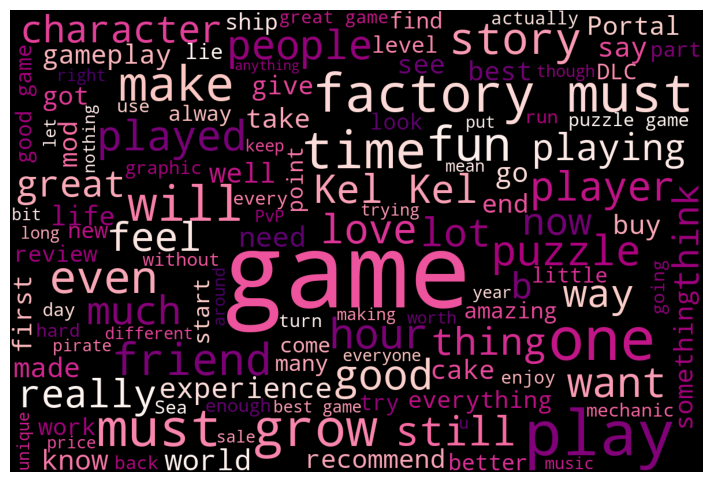

In [84]:
txt = ' '.join(i for i in df["review"])
wordcloud = WordCloud(max_font_size = 180,
                max_words = 120,
                width = 1200,
                height = 800,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

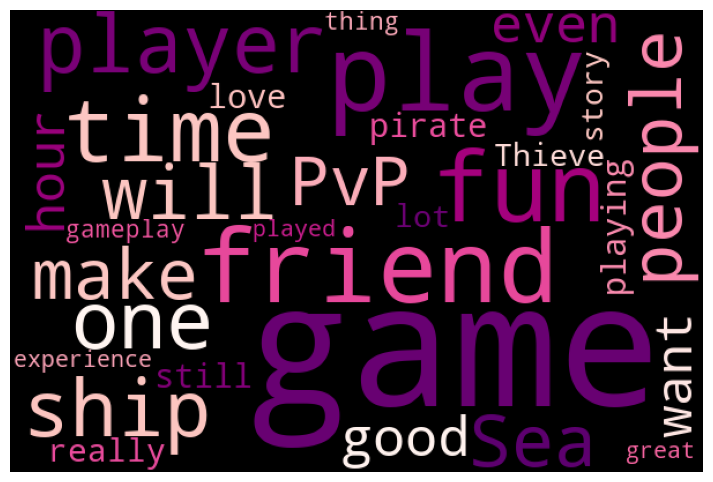

In [85]:
txt = ' '.join(i for i in df[df['genre'] == "A"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

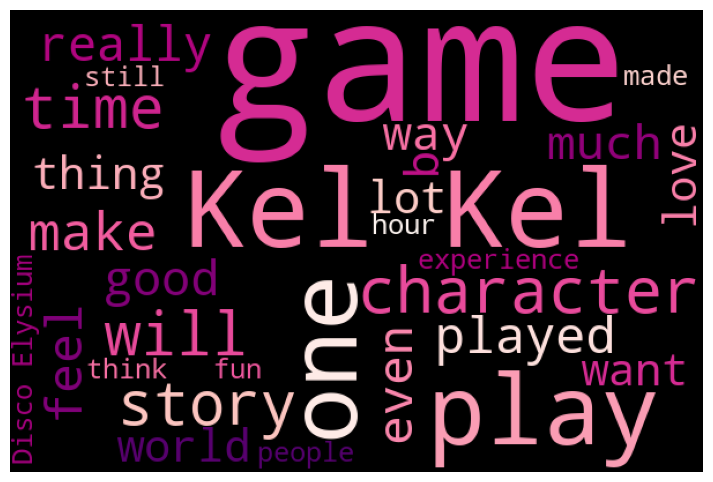

In [86]:
txt = ' '.join(i for i in df[df['genre'] == "R"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

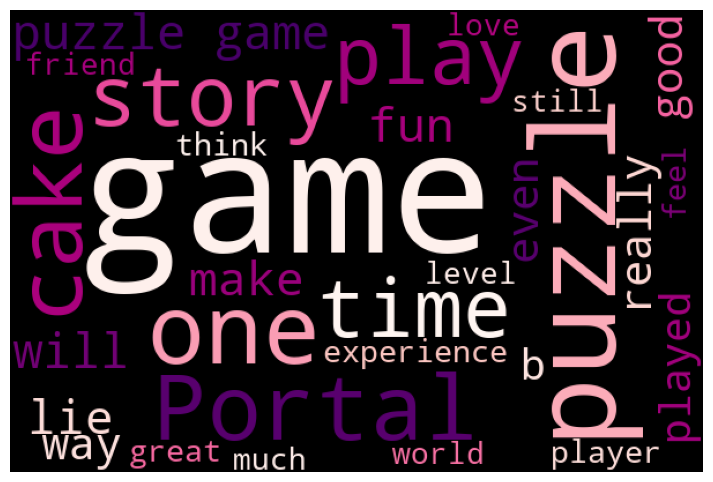

In [87]:
txt = ' '.join(i for i in df[df['genre'] == "P"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

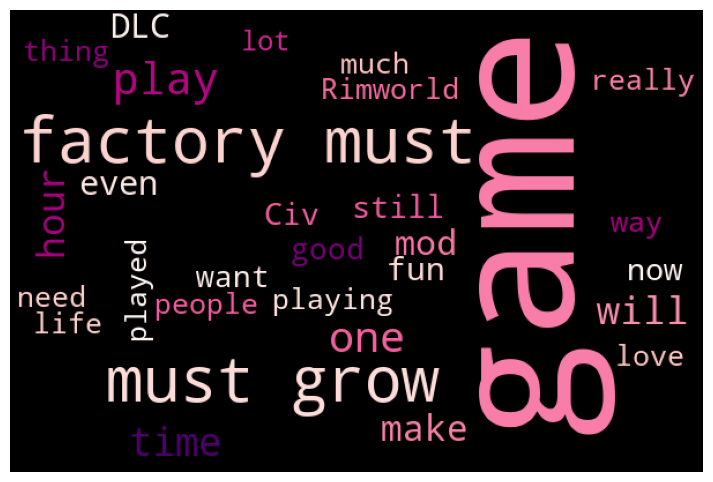

In [88]:
txt = ' '.join(i for i in df[df['genre'] == "S"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

#### Usunięcie znaków, text lowering

In [89]:
df["review"] = df["review"].str.replace(r"\[.*?\]|\n|[^\x00-\x7F]+", "", regex=True).str.lower()

In [90]:
df["review"].sample(10)

28188    i love this game, this work of art! it tickles...
26239    well here we are againit's always such a pleas...
22091                                 best game ever daddy
11218                                 it's alright i guess
27326    best coop logic game i've played and it's more...
6369     this is the first game in the series that i pl...
31844    i recommend this game even it there's a sectio...
23129    before i played this game, i had small boobs, ...
21062                               i need more cracktorio
14178                         it has begun.great game btw.
Name: review, dtype: object

#### Usunięcie znaków interpunkcyjnych i liczb

In [92]:
df["review"] = df["review"].str.replace(r"[0-9]", "", regex=True)

In [93]:
df["review"] = df["review"].str.replace('['  + string.punctuation + ']', "", regex =True)

In [94]:
df["review"].sample(5)

31005    one of the best deck builders to date and easy...
15525                                         me no likey 
19659    when i first bought this game i didnt give it ...
16814    dog shit game wheres the uwu anime chicks i ne...
30268    sumupindepth analysis further down pros cons t...
Name: review, dtype: object

#### Usunięcie tytułów gier z recenzji

In [96]:
for value in title_dict.values():
    df["review"] = df["review"].str.replace(value.lower(), "")

#### Tokenizacja

In [98]:
df["tokenized"] = df["review"].apply(nltk.word_tokenize)

In [99]:
df["tokenized"].sample(15)

28495    [like, a, lot, of, reviews, i, have, no, idea,...
29343                             [very, pog, very, champ]
7737     [goddamn, phones, i, fucking, hate, these, thi...
2990                           [uhh, cannon, go, pew, pew]
31720          [man, what, the, hell, happening, in, ohio]
21136                              [you, can, pet, a, cat]
20019             [most, constructive, game, i, ever, had]
10639    [it, can, be, a, litte, hard, but, if, you, un...
11111    [i, feel, like, civilization, was, better, i, ...
20782    [generates, million, a, year, has, employees, ...
17666    [incredibly, too, complicated, to, even, under...
6201     [edit, fyi, there, is, one, puzzle, in, the, l...
15824    [i, would, recommend, this, game, but, it, mad...
15058    [there, literally, is, an, achivement, for, nu...
4804                                [its, vere, bad, game]
Name: tokenized, dtype: object

### Stopwords

In [100]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
english_stopwords_cleaned = [word.replace("'", "") for word in english_stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [101]:
new_column = []
for row in df["tokenized"]:
    new_row = [word for word in row if word[0] not in english_stopwords_cleaned]
    new_column.append(new_row)
df["final_review"] = new_column

## Describe

In [103]:
df.dtypes

title                          object
genre                          object
steamid                        object
votes_up                        int64
review                         object
weighted_vote_score            object
voted_up                         bool
num_games_owned                 int64
playtime_at_review              int64
num_reviews                     int64
timestamp_created      datetime64[ns]
tokenized                      object
final_review                   object
dtype: object

In [104]:
df["weighted_vote_score"] = pd.to_numeric(df["weighted_vote_score"])

In [105]:
df["voted_up"] = pd.to_numeric(df["voted_up"])

In [106]:
df.describe()

,votes_up,weighted_vote_score,num_games_owned,playtime_at_review,num_reviews
count,26663.000000,26663.000000,26663.000000,2.666300e+04,26663.000000
mean,31.715148,0.570098,140.866707,1.309372e+04,21.467689
std,173.097223,0.109932,538.652824,4.720263e+04,59.809381
min,0.000000,0.500000,0.000000,5.000000e+00,1.000000
25%,1.000000,0.521739,0.000000,5.350000e+02,3.000000
50%,1.000000,0.523810,0.000000,1.800000e+03,8.000000
75%,3.000000,0.545180,113.000000,7.111500e+03,20.000000
max,9568.000000,0.987843,22780.000000,1.890626e+06,3419.000000


C:\Users\marty\AppData\Local\Temp\ipykernel_8224\2852639080.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method = "pearson")


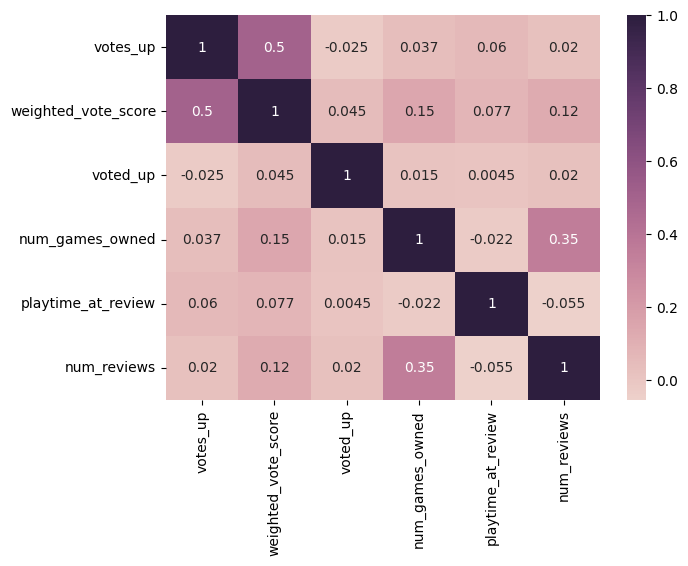

In [107]:
corr = df.corr(method = "pearson")
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap=sns.cubehelix_palette(as_cmap=True),annot=True)
plt.show()

## Wykresy

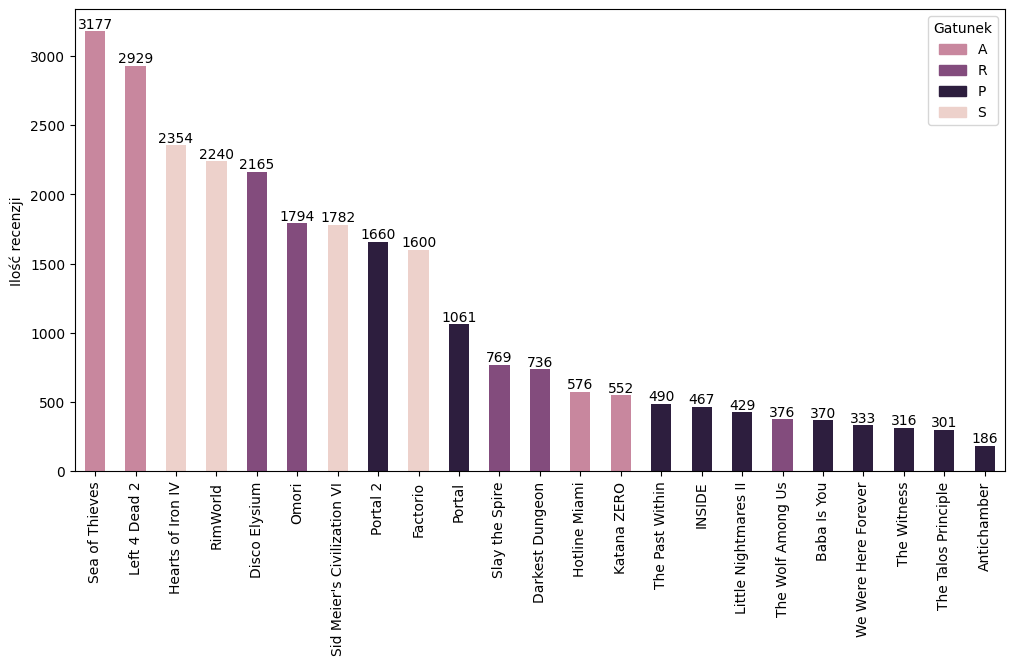

In [108]:
value_counts_title = df["title"].value_counts()
genre_colors = {"A": sns.cubehelix_palette(4)[1], "R": sns.cubehelix_palette(4)[2], "P": sns.cubehelix_palette(4)[3], 
                "S": sns.cubehelix_palette(4)[0]}
df['color'] = df['genre'].map(genre_colors)
colors = [df.loc[df['title'] == title]['color'].iloc[0] for title in value_counts_title.index]

plt.figure(figsize=(12, 6))
x = value_counts_title.plot(kind = "bar", color = colors)
plt.ylabel("Ilość recenzji")
plt.xticks(rotation = 90)
for i, count in enumerate(value_counts_title):
    x.text(i, count, count, va = "bottom", ha = "center")

handles = [plt.Rectangle((0,0), 1,1, color=genre_colors[label]) for label in genre_colors]
plt.legend(handles, genre_colors.keys(), title="Gatunek", loc="upper right")


plt.show()
df = df.drop(["color"], axis=1)

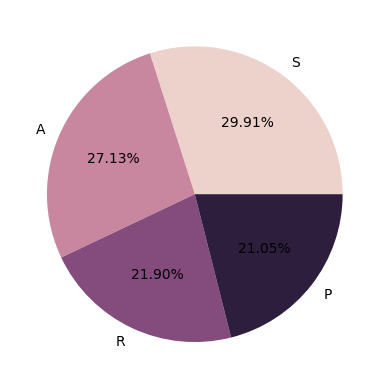

In [109]:
value_counts_genre = df["genre"].value_counts()
colors = sns.cubehelix_palette(4)
x = plt.pie(value_counts_genre, labels = value_counts_genre.index, colors=colors, autopct='%1.2f%%')
plt.show()

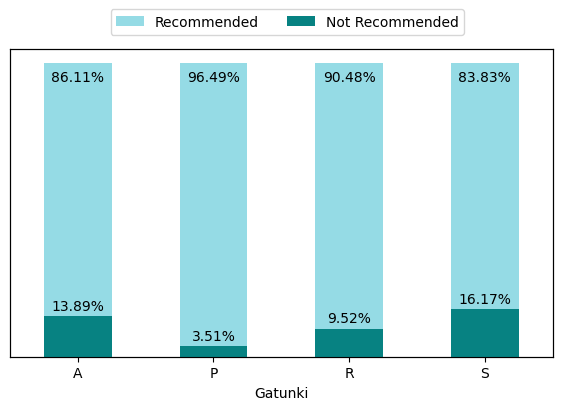

In [110]:
value_counts_recommendation_genre = df.groupby('genre').voted_up.value_counts().unstack(0)
percentage_pos = value_counts_recommendation_genre.iloc[1] / (value_counts_recommendation_genre.iloc[1] + value_counts_recommendation_genre.iloc[0]) * 100 
percentage_neg = value_counts_recommendation_genre.iloc[0] / (value_counts_recommendation_genre.iloc[0] + value_counts_recommendation_genre.iloc[1]) * 100 

total_count = percentage_pos + percentage_neg

def addlabels_neg(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] + 2, f"{x[i]:.2f}%",  ha = "center")

def addlabels_pos(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] - 6, f"{y[i]:.2f}%",  ha = "center")

fig, ax1 = plt.subplots(figsize=(7, 4))
ax2 = ax1.twinx()

total_count.plot(kind="bar", color="#95DBE5FF",  label="Recommended")
percentage_neg.plot(kind="bar", color="#078282FF", label="Not Recommended")

ax1.set_xlabel("Gatunki")
ax1.tick_params(axis="y", left=False, labelleft=False)
ax2.tick_params(axis="y", right=False, labelright=False)

addlabels_neg(percentage_neg, total_count) 
addlabels_pos(total_count, percentage_pos) 

plt.legend(bbox_to_anchor=(0.85, 1.15), ncol=2)
plt.show()

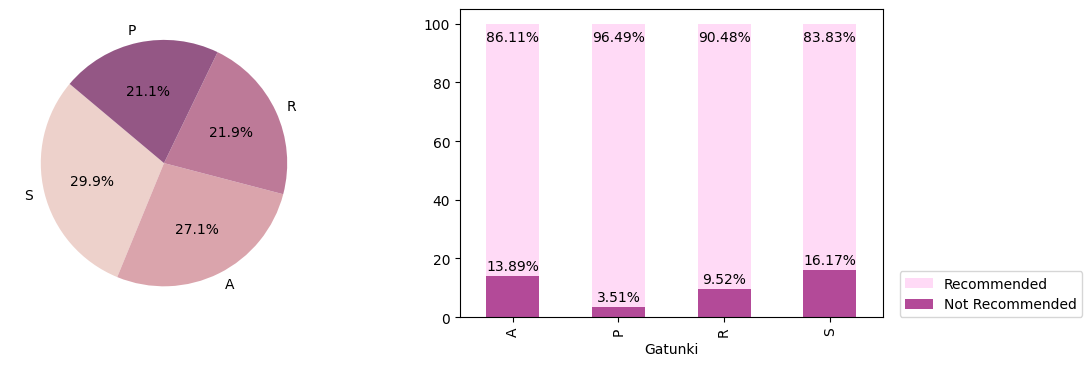

In [111]:
import numpy as np

value_counts_recommendation_genre = df.groupby('genre').voted_up.value_counts().unstack(0)
percentage_pos = value_counts_recommendation_genre.iloc[1] / (value_counts_recommendation_genre.iloc[1] + value_counts_recommendation_genre.iloc[0]) * 100 
percentage_neg = value_counts_recommendation_genre.iloc[0] / (value_counts_recommendation_genre.iloc[0] + value_counts_recommendation_genre.iloc[1]) * 100 

total_count = percentage_pos + percentage_neg

def addlabels_neg(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] + 2, f"{x[i]:.2f}%",  ha = "center")

def addlabels_pos(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] - 6, f"{y[i]:.2f}%",  ha = "center")

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

total_count.plot(kind="bar", color="#ffdaf6",  label="Recommended")
percentage_neg.plot(kind="bar", color="#b34a98", label="Not Recommended")

axs[1].set_xlabel("Gatunki")
addlabels_neg(percentage_neg, total_count) 
addlabels_pos(total_count, percentage_pos) 
axs[1].legend(loc=(1.04, 0))

value_counts_genre = df["genre"].value_counts()
colors = sns.cubehelix_palette(6)

axs[0].pie(value_counts_genre, labels = value_counts_genre.index,colors=colors, autopct='%1.1f%%', startangle=140)
plt.show()

## Dependency parser test

In [112]:
test = [df["final_review"][6543], df["final_review"][4534], df["final_review"][12345], df["final_review"][12354],
        df["final_review"][1925], df["final_review"][1067],df["final_review"][22951],df["final_review"][2231],
       ["not","fun", "gameplay"], df["tokenized"][832], df["final_review"][21], df["tokenized"][27061],
       df["final_review"][11088], df["final_review"][3171], df["final_review"][7834], df["final_review"][20180],
       df["final_review"][6697], df["final_review"][893]]

In [113]:
import stanza
nlp = stanza.Pipeline('en', tokenize_pretokenized=True) 
doc = nlp(test)

2024-06-28 14:28:40 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-06-28 14:28:40 INFO: Downloaded file to C:\Users\marty\stanza_resources\resources.json
2024-06-28 14:28:41 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-06-28 14:28:41 INFO: Using device: cuda
2024-06-28 14:28:41 INFO: Loading: tokenize
2024-06-28 14:28:41 INFO: Loading: mwt
2024-06-28 14:28:41 INFO: Loading: pos
2024-06-28 14:28:42 INFO: Loading: lemma
2024-06-28 14:28:42 INFO: Loading: constituency
2024-06-28 14:28:42 INFO: Loading: depparse
2024-06-28 14:28:42 INFO: Loading: sentiment
2024-06-28 14:28:43 INFO: Loading: ne

In [114]:
dependency_list = []
for dependency in doc.sentences[13].dependencies:
    dependency_list.append([dependency[2].text, dependency[0].id, dependency[1]])
    
for i in range(0, len(dependency_list)):
    if (int(dependency_list[i][1]) != 0):
        dependency_list[i][1] = test[13][(int(dependency_list[i][1]) - 1)]

print(*dependency_list[:10], sep='\n')

['crewing', 0, 'root']
['game', 'value', 'compound']
['value', 'crewing', 'obj']
['likely', 'crewing', 'advmod']
['worthless', 'crewing', 'xcomp']
['real', 'crewing', 'xcomp']
['but', 'play', 'cc']
['can', 'play', 'aux']
['play', 'crewing', 'conj']
['player', 'play', 'obj']


In [115]:
feature_list = []
feature_opinion_list = [] 

for dependency in doc.sentences[13].dependencies:
    if dependency[2].xpos == "RB":
        opinion_word = dependency[2]
        rb_adj = dependency[0]
        
    if (dependency[2].xpos in ["NN", "NNS","JJ", "JJS", "JJR"]) and (dependency[1] in ["amod"]):
        if dependency[0] == rb_adj or dependency[2] == rb_adj:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].lemma}     
        else:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].lemma}  

        feature_list.append(dependency[0].lemma)
        feature_opinion_list.append(result_dict)

print(f'Feature list: {feature_list}')
print(f'Feature-opinion list: {feature_opinion_list}')

Feature list: ['graphic', 'beauty', 'player', 'player', 'player', 'guide', 'reward', 'reward', 'reward']
Feature-opinion list: [{'feature': 'graphic', 'opinion': 'fun'}, {'feature': 'beauty', 'opinion': 'real'}, {'feature': 'player', 'opinion': 'unbalanced'}, {'feature': 'player', 'opinion': 'janky'}, {'feature': 'player', 'opinion': 'human'}, {'feature': 'guide', 'opinion': 'necessary'}, {'feature': 'reward', 'opinion': 'risky'}, {'feature': 'reward', 'opinion': 'lowest'}, {'feature': 'reward', 'opinion': 'highest'}]


## Dependency parser final

In [116]:
with open('opinions.json', 'r') as file:
    dct = json.load(file)

In [117]:
feature_list = []

for i in range(len(df)):
    index = str(i)  
    feature = dct.get(index)
    if feature is None:
        feature_list.append([])
    else:
        feature_list.append(feature)

df["feature"] = feature_list

In [118]:
df = df[df["feature"].apply(lambda x: len(x) > 0)]

In [119]:
words = []
for i in df["feature"]:
    for j in i:
        words.append(j["feature"])

In [120]:
unique_words = list(set(words))

In [121]:
word_counts = pd.DataFrame([[i, len([q for q in words if q==i])] for i in unique_words], 
              columns=['word', 'count']).sort_values('count', ascending=False)

## Dendrogram

In [122]:
popular_words = word_counts[word_counts['count']>= 15]["word"].to_list()
nlp = spacy.load('en_core_web_md')
tokens = [nlp(word) for word in popular_words]
word_vectors = pd.DataFrame([i.vector for i in tokens])

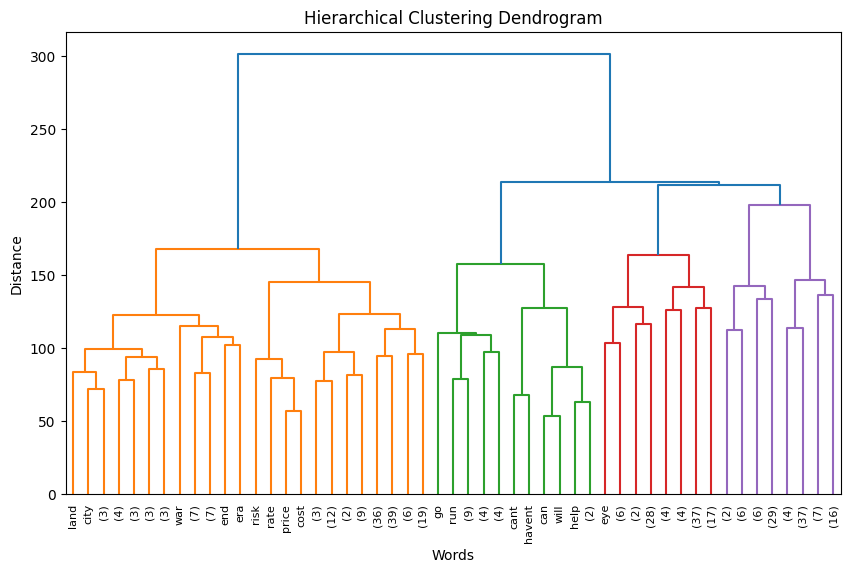

In [123]:
Z = linkage(word_vectors.values, method='ward')

plt.figure(figsize=(10,6))
dendrogram(Z, p = 5, truncate_mode = "level", orientation='top', labels = popular_words, leaf_font_size = 8)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Words')
plt.ylabel('Distance')
plt.show()

In [124]:
cluster_labels = fcluster(Z, t = 75,  criterion="distance")

clusters = {}
for word, label in zip(popular_words, cluster_labels):
    if label not in clusters:
        clusters[label] = [word]
    else:
        clusters[label].append(word)

for label, words in clusters.items():
    print(f"Cluster {label}: {', '.join(words)}")

Cluster 68: game, play, player, playing
Cluster 57: puzzle, pirate, horror, zomby, zombie, pawn, wolf, franchise, coop, nightmare, limbo, pve, gamei, fable, eargasm, glado, clue, cannibal, chill, hacker
Cluster 21: experience, community, work, environment, resource, workshop, focus, knowledge, research, project, practice, learning
Cluster 75: gameplay, gamer, gaming, rng, bonus, replay, cue
Cluster 99: way, pace
Cluster 97: hour, week, night
Cluster 12: price, cost
Cluster 47: person, friend, boss, child, woman, family, partner
Cluster 48: love, choice, voice, wish, reward, hope, enjoyment, pleasure, praise
Cluster 62: character, hero, genre, plot, figure, episode, cutscene, lore, chapter, legend, protagonist, narrator, backstory
Cluster 1: world, city, country, nation
Cluster 54: fun
Cluster 19: level, point, number, class, rating
Cluster 72: review, note, view, guide
Cluster 76: graphic, visual, video, pixel
Cluster 18: content, quality, value, product
Cluster 52: lot
Cluster 4: part

In [125]:
def words_to_list(words_string):
    return words_string.split()

clusters_df = pd.read_csv('clusters.csv', converters={'Words': words_to_list})
clusters_df

,Cluster,Words
0,68,"[game, play, player, playing]"
1,57,"[puzzle, pirate, horror, zomby, pawn, zombie, ..."
2,21,"[experience, community, work, environment, res..."
3,75,"[gameplay, gamer, gaming, rng, bonus, replay, ..."
4,99,"[way, pace]"
...,...,...
98,13,[rate]
99,74,[key]
100,44,[role]
101,2,[land]


In [126]:
clusters = {7: 'Combat',
    95: 'Combat',
    11: "Combat",
    75: 'Gameplay',
    19: 'Game Mechanics',
    99: 'Game Mechanics',
    25: 'Challenges',
    76: 'Visuals',
    87: 'Visuals',
    67: 'Visuals',
    56: 'Humor',
    62: 'Narrative and Story',
    22: 'Narrative and Story',
    63: 'Bugs and Glitches',
    77: 'Updates and Patches',
    21: 'Community and Collaboration',
    12: 'Cost',
    24: 'Cost',
    18: 'Content Quality',
    8: 'Quests and Adventures',
    16: 'Production and Development',
    72: 'User Feedback',
    48: 'Enjoyment and Reward'}

In [127]:
categories = clusters_df.groupby(clusters_df['Cluster'].map(clusters)).agg({'Words': 'sum'}).reset_index()
categories

,Cluster,Words
0,Bugs and Glitches,"[bug, glitch]"
1,Challenges,"[challenge, problem, effect, reason, possibili..."
2,Combat,"[enemy, fight, battle, combat, campaign, effor..."
3,Community and Collaboration,"[experience, community, work, environment, res..."
4,Content Quality,"[content, quality, value, product]"
5,Cost,"[price, cost, worth, waste, purchase, payment,..."
6,Enjoyment and Reward,"[love, choice, voice, wish, reward, hope, enjo..."
7,Game Mechanics,"[way, pace, level, point, number, class, rating]"
8,Gameplay,"[gameplay, gamer, gaming, rng, bonus, replay, ..."
9,Humor,"[humor, classic, vibe, gem, hint, quirk, charm]"


In [128]:
categories["Words"][15]

['graphic', 'visual', 'video', 'pixel', 'color', 'paint', 'light', 'ui']

## Similarity

In [129]:
words = word_counts["word"].to_list()
nlp = spacy.load('en_core_web_md')
tokens = [nlp(word) for word in words]

In [130]:
categories['WordTokens'] = categories['Words'].apply(lambda words: [nlp(word) for word in words])
all_cluster_words = set(word for words in categories['Words'] for word in words)
print(all_cluster_words)

for token in tokens:
    max_similarity = 0
    best_cluster = None
    
    for idx, row in categories.iterrows():
        for word_token in row['WordTokens']:
            similarity = token.similarity(word_token)
            if similarity > max_similarity:
                max_similarity = similarity
                best_cluster = idx
    
    if max_similarity > 0.75 and str(token) not in all_cluster_words:
        categories.at[best_cluster, 'Words'].append(str(token))
        all_cluster_words.add(token)
        print(token, max_similarity, best_cluster)


categories.drop(columns=['WordTokens'], inplace=True)
print(categories)

{'gamer', 'cost', 'war', 'light', 'voyage', 'level', 'enjoyment', 'buying', 'character', 'lore', 'chapter', 'knowledge', 'number', 'way', 'humor', 'color', 'battle', 'bug', 'chance', 'campaign', 'production', 'combat', 'pixel', 'future', 'network', 'graphic', 'protagonist', 'colonist', 'resource', 'factor', 'pleasure', 'version', 'bomb', 'journey', 'focus', 'note', 'unit', 'choice', 'equipment', 'balance', 'episode', 'question', 'learning', 'upgrade', 'practice', 'class', 'victory', 'point', 'factory', 'enemy', 'workshop', 'charm', 'location', 'purchase', 'credit', 'quirk', 'narrator', 'problem', 'base', 'research', 'hint', 'cue', 'platformer', 'content', 'praise', 'cutscene', 'nature', 'backstory', 'plant', 'platform', 'hero', 'plot', 'vision', 'environment', 'empire', 'voice', 'purpose', 'value', 'gameplay', 'classic', 'colony', 'vibe', 'legend', 'feature', 'waste', 'effect', 'gem', 'reality', 'possibility', 'rng', 'worth', 'writing', 'release', 'weapon', 'wish', 'glitch', 'rating', 

C:\Users\marty\AppData\Local\Temp\ipykernel_8224\3944219790.py:11: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity = token.similarity(word_token)


narration 0.9999999521958635 10
colour 0.9479376452124644 15
foe 1.000000091474777 2
understanding 0.8729436719411919 3
fort 0.865434181556071 12
essence 0.7759934862824474 10
consequence 0.8084028401712441 1
reading 0.7708820667514156 10
launch 0.8510425976339058 13
folk 0.782176930005155 10
flair 1.0000000027919722 9
pricing 0.7757885714113014 5
videogame 1.0000000224913246 15
gamemode 0.772078233377223 8
philosopher 0.7927748648450301 10
biome 0.7606400507093212 3
banter 0.9470238821603723 9
principle 0.7580843855296748 10
blight 0.9999999565292808 15
composition 0.7561159861499832 11
context 0.821453755634528 10
construction 0.7728575355453692 11
contradiction 0.783415311522307 10
reflection 0.7538657703921289 10
behaviour 0.9639961313515717 10
nostalgia 1.0000000007603036 9
gametime 0.772078233377223 8
probability 0.8254659537705171 1
pastiche 0.7675241807232946 9
experiance 0.9999999623013374 3
platforming 1.0000000567238878 11
reviewer 0.7815022561331578 14
humour 0.947023882160

In [131]:
categories["Words"][15]

['graphic',
 'visual',
 'video',
 'pixel',
 'color',
 'paint',
 'light',
 'ui',
 'colour',
 'videogame',
 'blight',
 'lightbulb',
 'paintjob',
 'colourblind',
 'gui',
 'colorblindness',
 'lighting',
 'colorblind']

# Feature-opinion-category list

In [132]:
for i in df["feature"]:
    for j in i:
        for index, row in categories.iterrows():
            if j["feature"] in row["Words"]:
                j["category"] = row["Cluster"]